# Libraries

In [1]:
!pip install plotly
!pip install Lifetimes

In [2]:
import os
import datetime
import datetime as dt
import squarify

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from operator import attrgetter

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
#%matplotlib inline
palette = 'Set2'

# Load and understand data

In [3]:
retail=pd.read_csv(r"C:\Users\Lenovo\OneDrive\Desktop\datasets\OnlineRetail.csv",encoding='latin-1')

In [4]:
retail.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [5]:
def check_data(dataframe, head=5):
    print(" Shape ".center(70,'-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" Types ".center(70,'-'))
    print(dataframe.dtypes)
    print(" Head ".center(70,'-'))
    print(dataframe.head(head))
    print(" Tail ".center(70,'-'))
    print(dataframe.tail(head))
    print(" Missing values ".center(70,'-'))
    print(dataframe.isnull().sum())
    print(" Duplicated values ".center(70,'-'))
    print(dataframe.duplicated().sum())
    print(" Quantiles ".center(70,'-'))
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_data(retail)

------------------------------- Shape --------------------------------
Rows: 541909
Columns: 8
------------------------------- Types --------------------------------
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object
-------------------------------- Head --------------------------------
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8

<AxesSubplot:>

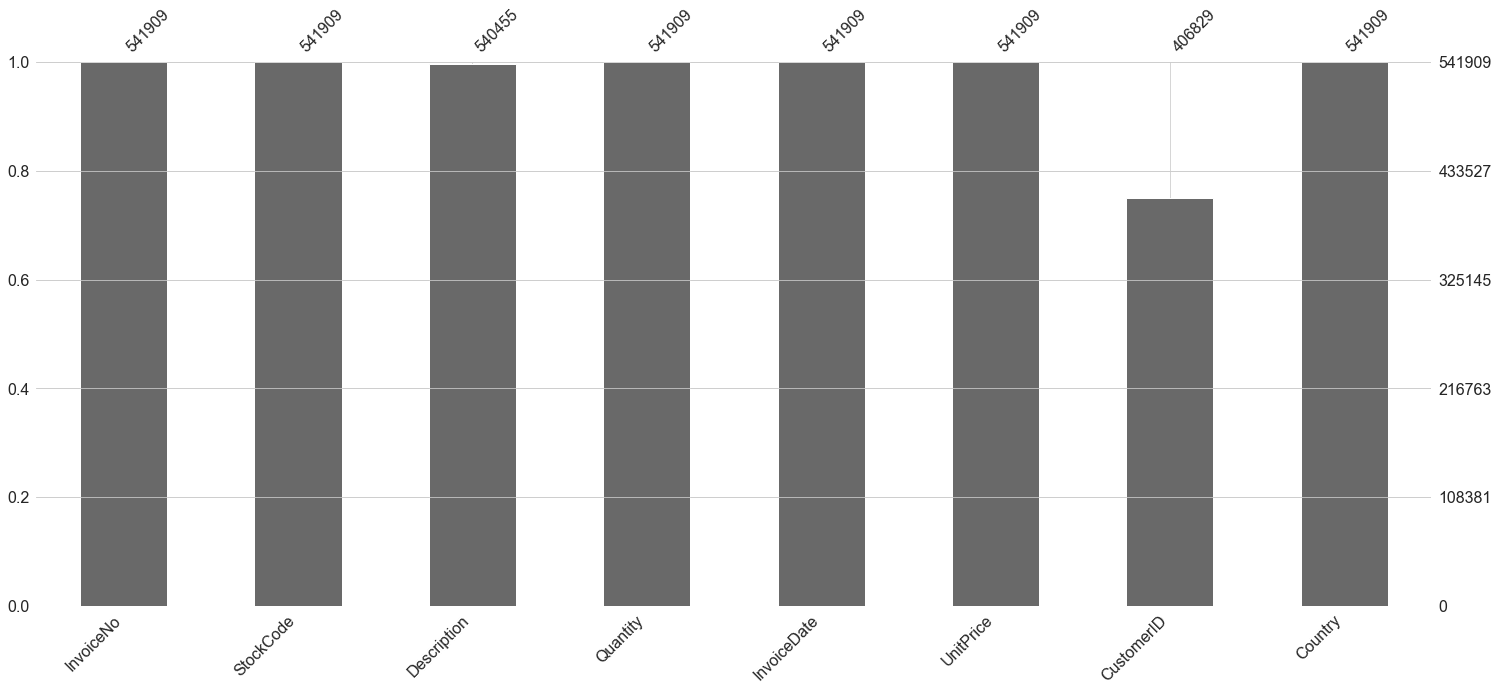

In [6]:
import missingno as msno
msno.bar(retail)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'Quantity'),
  Text(0, 1.5, 'UnitPrice'),
  Text(0, 2.5, 'CustomerID')])

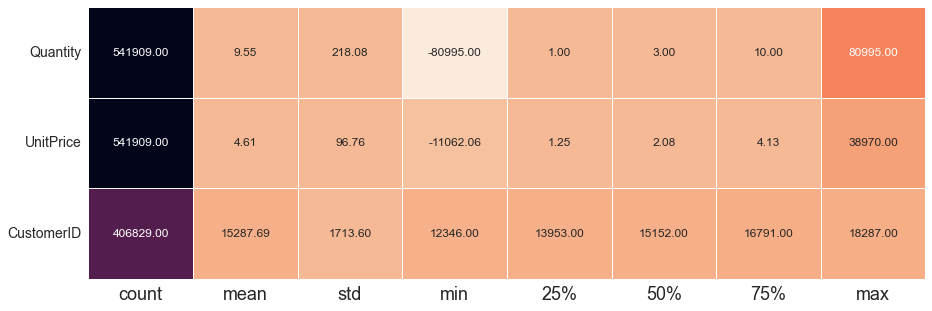

In [7]:
import seaborn as sns
data=pd.DataFrame(retail.describe().T)
ax=plt.figure(figsize=(15,5))
sns.heatmap(data,annot=True,cmap='rocket_r',linewidths=1,cbar=False,annot_kws = {"size": 12},fmt = '.2f')
plt.xticks(size = 18)
plt.yticks(size = 14,rotation = 0)

In [8]:
world_map = retail[['CustomerID', 'InvoiceNo', 'Country']
              ].groupby(['CustomerID', 'InvoiceNo', 'Country']
                       ).count().reset_index(drop = False)
countries = world_map['Country'].value_counts()

map = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nos.'},
colorscale=[[0, 'rgb(0,102,102)'],
            [0.01, 'rgb(0,204,204)'], [0.07, 'rgb(0,255,255)'],[0.153, 'rgb(102,178,255)'],
            [0.230, 'rgb(255,255,102)'],[0.307,'rgb(102,178,255)'],[0.461, 'rgb(204,0,0)'],
            [0.538, 'rgb(0,128,255)'],[0.615, 'rgb(0,25,51)'], [0.769, 'rgb(204,229,255)'],
            [0.846, 'rgb(255,153,51)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
layout = dict(title='Number of orders by countries',
geo = dict(showframe = True, projection={'type':'robinson'},showocean = True,
                         oceancolor = "LightBlue",
                         showland = True,
                         landcolor = "whitesmoke"))

choromap = go.Figure(data = [map], layout = layout)
iplot(choromap, validate=True)

In [9]:
retail = retail.dropna()
retail.shape

(406829, 8)

# Descriptive statistics

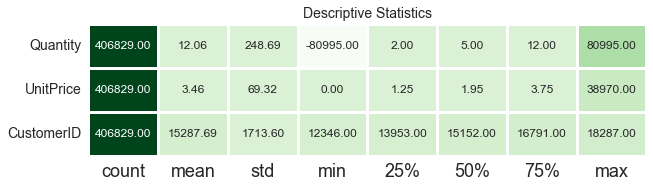

In [10]:
def desc_stats(dataframe):
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= dataframe.describe().T.columns,
                           data= dataframe.describe().T)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0] * 0.81))
    sns.heatmap(desc_df,
                annot = True,
                cmap = "Greens",
                fmt = '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.1,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(retail.select_dtypes(include = [float, int]))


In [11]:
retail.loc[:,'CustomerID']=retail.loc[:,'CustomerID'].astype(str)
retail

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice CustomerID         Country  
0        12/1/2010 8:26       2.55    17850.0  United Kingdom  
1        12/1/2010 8:26       3.39    17850.0  United Kingdom  
2        12/1/2010 8:26       2.75    17850.0  United Kingdom  
3        12/1/2010 8:26       3.39    17850.0  United Kingdom  
4        12/1/2010 8:26       3.39    17850.0  United Kingdom  
...                 ...        ...        ...             ...  
541904  12/9/2011 12:50       0.85    12680.0          France  
541905  12/9/2011 12:50       2.10    12680.0          France  
541906  12/9/2011 12:50       4.15    12680.0          France  
541907  12/9/2011 12:50       4.15    12680.0          France  
541908  12/9/2011 12:50       4.95    12680.0          France  

[406829 rows x 8 columns]

Text(0.5, 0, 'Attributes')

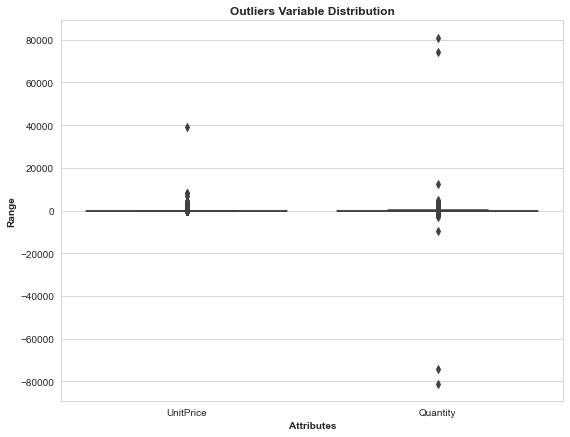

In [12]:
attributes=['UnitPrice','Quantity']
plt.figure(figsize=(9,7))

sns.boxplot(data=retail[attributes])

plt.title("Outliers Variable Distribution", fontsize = 12, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

# RFM Analysis

# RFM Metrics

In [13]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d/%m/%Y %H:%M',infer_datetime_format=True)

In [14]:
max_date=retail['InvoiceDate'].max()
max_date

Timestamp('2011-12-09 12:50:00')

In [15]:
retail['Diff']=max_date - retail['InvoiceDate']

In [16]:
retail.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country              Diff  
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom 373 days 04:24:00  
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom 373 days 04:24:00  
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom 373 days 04:24:00  
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom 373 days 04:24:00  
4 2010-12-01 08:26:00       3.39    17850.0  United Kingdom 373 days 04:24:00

In [17]:
retail['TotalPrice']=retail['Quantity']*retail['UnitPrice']
retail

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  \
0      2010-12-01 08:26:00       2.55    17850.0  United Kingdom   
1      2010-12-01 08:26:00       3.39    17850.0  United Kingdom   
2      2010-12-01 08:26:00       2.75    17850.0  United Kingdom   
3      2010-12-01 08:26:00       3.39    17850.0  United Kingdom   
4      2010-12-01 08:26:00       3.39    17850.0  United Kingdom   
...                    ...        ...        ...             ...   
541904 2011-12-09 12:50:00       0.85    12680.0          France   
541905 2011-12-09 12:50:00       2.10    12680.0          France   
541906 2011-12-09 12:50:00       4.15    12680.0          France   
541907 2011-12-09 12:50:00       4.15    12680.0          France   
541908 2011-12-09 12:50:00       4.95    12680.0          France   

                    Diff  TotalPrice  
0      373 days 04:24:00       15.30  
1      373 days 04:24:00       20.34  
2      373 days 04:24:00       22.00  
3      373 days 04:24:00       20.34  
4      373 days 04:24:00       20.34  
...                  ...         ...  
541904   0 days 00:00:00       10.20  
541905   0 days 00:00:00       12.60  
541906   0 days 00:00:00       16.60  
541907   0 days 00:00:00       16.60  
541908   0 days 00:00:00       14.85  

[406829 rows x 10 columns]

In [18]:
import datetime as dt

rfm = retail.groupby('CustomerID').agg({'InvoiceDate': lambda x: (max_date - x.max()).days,'InvoiceNo': lambda x: x.count(),'TotalPrice': lambda x: x.sum()})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm = rfm.reset_index()
rfm.head()


CustomerID  Recency  Frequency  Monetary
0    12346.0      325          2      0.00
1    12347.0        1        182   4310.00
2    12348.0       74         31   1797.24
3    12349.0       18         73   1757.55
4    12350.0      309         17    334.40

In [19]:
rfm.shape

(4372, 4)

In [20]:
rfm.describe()

Recency    Frequency       Monetary
count  4372.000000  4372.000000    4372.000000
mean     91.047118    93.053294    1898.459701
std     100.765435   232.471608    8219.345141
min       0.000000     1.000000   -4287.630000
25%      16.000000    17.000000     293.362500
50%      49.000000    42.000000     648.075000
75%     142.000000   102.000000    1611.725000
max     373.000000  7983.000000  279489.020000

Text(0.5, 0, 'Attributes')

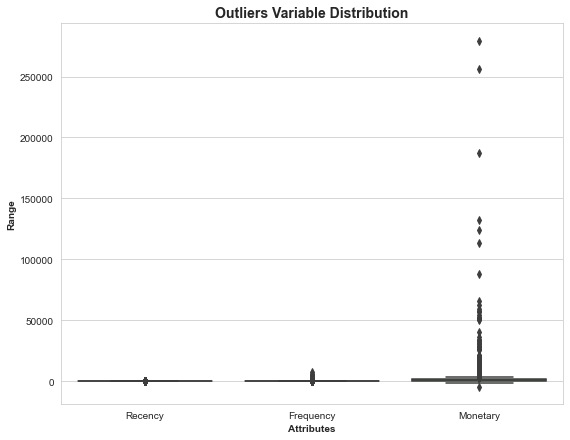

In [21]:
attributes = ['Recency','Frequency','Monetary']
plt.figure(figsize=(9,7))

sns.boxplot(data = rfm[attributes])

plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [22]:
# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]


# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]


# Removing (statistical) outliers for Monetary
Q1 = rfm.Monetary.quantile(0.05)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]

In [23]:
rfm

CustomerID  Recency  Frequency  Monetary
0       12346.0      325          2      0.00
1       12347.0        1        182   4310.00
2       12348.0       74         31   1797.24
3       12349.0       18         73   1757.55
4       12350.0      309         17    334.40
...         ...      ...        ...       ...
4367    18280.0      277         10    180.60
4368    18281.0      180          7     80.82
4369    18282.0        7         13    176.60
4370    18283.0        3        756   2094.88
4371    18287.0       42         70   1837.28

[4290 rows x 4 columns]

# RFM Scores

In [24]:
def get_rfm_scores(dataframe):
    
    retail_ = dataframe.copy()
    retail_['recency_score'] = pd.qcut(retail_['Recency'],5,labels=[5, 4, 3, 2, 1])
    retail_['frequency_score'] = pd.qcut(retail_['Frequency'].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])
    retail_['monetary_score'] = pd.qcut(retail_['Monetary'], 5, labels = [1, 2, 3, 4, 5])
    retail_['RFM_SCORE'] = (retail_['recency_score'].astype(str) + retail_['frequency_score'].astype(str))
    
    return retail_

rfm= get_rfm_scores(rfm)

In [25]:
rfm

CustomerID  Recency  Frequency  Monetary recency_score frequency_score  \
0       12346.0      325          2      0.00             1               1   
1       12347.0        1        182   4310.00             5               5   
2       12348.0       74         31   1797.24             2               3   
3       12349.0       18         73   1757.55             4               4   
4       12350.0      309         17    334.40             1               2   
...         ...      ...        ...       ...           ...             ...   
4367    18280.0      277         10    180.60             1               1   
4368    18281.0      180          7     80.82             2               1   
4369    18282.0        7         13    176.60             5               2   
4370    18283.0        3        756   2094.88             5               5   
4371    18287.0       42         70   1837.28             3               4   

     monetary_score RFM_SCORE  
0                 1        11  
1                 5        55  
2                 4        23  
3                 4        44  
4                 2        12  
...             ...       ...  
4367              1        11  
4368              1        21  
4369              1        52  
4370              5        55  
4371              4        34  

[4290 rows x 8 columns]

# Segmentation

In [26]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)

rfm.head()

CustomerID  Recency  Frequency  Monetary recency_score frequency_score  \
0    12346.0      325          2      0.00             1               1   
1    12347.0        1        182   4310.00             5               5   
2    12348.0       74         31   1797.24             2               3   
3    12349.0       18         73   1757.55             4               4   
4    12350.0      309         17    334.40             1               2   

  monetary_score RFM_SCORE          segment  
0              1        11      hibernating  
1              5        55        champions  
2              4        23          at_Risk  
3              4        44  loyal_customers  
4              2        12      hibernating

# Segmentation Map

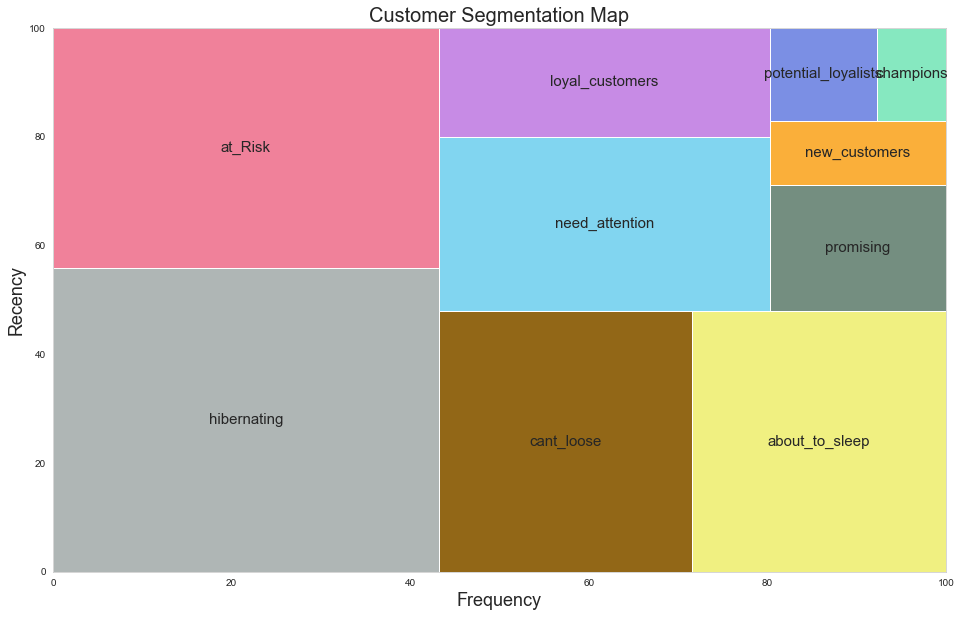

In [27]:
segments = rfm['segment'].value_counts().sort_values(ascending = False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(sizes=segments,
              label=[label for label in seg_map.values()],
              color=['#AFB6B5', '#F0819A', '#926717', '#F0F081', '#81D5F0',
                     '#C78BE5', '#748E80', '#FAAF3A', '#7B8FE4', '#86E8C0'],
              pad = False,
              bar_kwargs = {'alpha': 1},
              text_kwargs = {'fontsize':15})
plt.title("Customer Segmentation Map", fontsize = 20)
plt.xlabel('Frequency', fontsize = 18)
plt.ylabel('Recency', fontsize = 18)
plt.show()

# Model Evaluation

In [28]:
print(' RFM Model Evaluation '.center(70, '='))
X = rfm[['recency_score', 'frequency_score']]
labels = rfm['segment']
print(f'Number of Observations: {X.shape[0]}')
print(f'Number of Segments: {labels.nunique()}')
print(f'Silhouette Score: {round(silhouette_score(X, labels), 3)}')
print(f'Calinski Harabasz Score: {round(calinski_harabasz_score(X, labels), 3)}')
print(f'Davies Bouldin Score: {round(davies_bouldin_score(X, labels), 3)} \n{70*"="}')

======================== RFM Model Evaluation ========================
Number of Observations: 4290
Number of Segments: 10
Silhouette Score: 0.463
Calinski Harabasz Score: 4453.012
Davies Bouldin Score: 0.644 


# Segment Analysis

In [29]:
rfm[['Recency','Monetary','Frequency','segment']]\
.groupby('segment')\
.agg({'mean','std','max','min'})

Recency                                  Monetary  \
                        min        std        mean  max           min   
segment                                                                 
about_to_sleep           33  11.079571   52.678233   71 -1.165300e+03   
at_Risk                  72  83.243801  167.164384  373 -9.593000e+01   
cant_loose               72  67.866456  141.227273  337  4.115300e+02   
champions                 0   3.567006    4.905822   11  1.816700e+02   
hibernating              72  89.452095  213.162476  373 -4.287630e+03   
loyal_customers          12  15.917021   32.935287   71  0.000000e+00   
need_attention           33  11.196307   51.459184   71 -5.684342e-14   
new_customers             0   3.323275    5.714286   10 -1.745000e+01   
potential_loyalists       0   9.532346   14.929550   32 -1.776357e-15   
promising                13   5.640448   22.158416   32  0.000000e+00   

                                                        Frequency              \
                             std         mean       max       min         std   
segment                                                                         
about_to_sleep        682.161658   437.322524   7330.80         1    7.815068   
at_Risk               987.502143   927.632226  11056.93        29   22.475167   
cant_loose           1656.531847  2249.420920  10217.48       118   71.969571   
champions            2497.561267  3071.089486  12650.08        57  143.497372   
hibernating           519.316497   336.680911   7092.06         1    8.003618   
loyal_customers      1801.866317  2123.898413  11341.10        56  102.414032   
need_attention       1007.029154   809.805510  11581.80        29    7.985484   
new_customers        1904.660354   689.115357  12393.70         1    3.813467   
potential_loyalists   862.980975   763.699004  11990.96        13   12.302110   
promising             793.906901   405.645644   6748.80         1    3.620103   

                                      
                           mean  max  
segment                               
about_to_sleep        15.432177   29  
at_Risk               54.895548  117  
cant_loose           177.886364  548  
champions            200.601027  756  
hibernating           13.088975   29  
loyal_customers      149.448107  757  
need_attention        40.464286   56  
new_customers          7.303571   13  
potential_loyalists   33.551859   56  
promising              6.930693   13

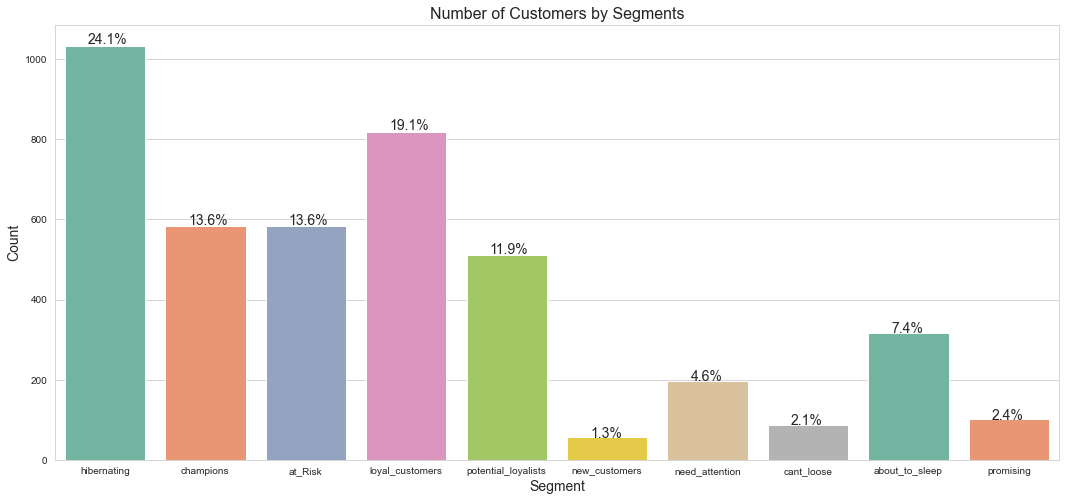

In [30]:
plt.figure(figsize = (18, 8))
ax = sns.countplot(data = rfm,
                   x = 'segment',
                   palette = palette)
total = len(rfm.segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
plt.title('Number of Customers by Segments', size = 16)
plt.xlabel('Segment', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()


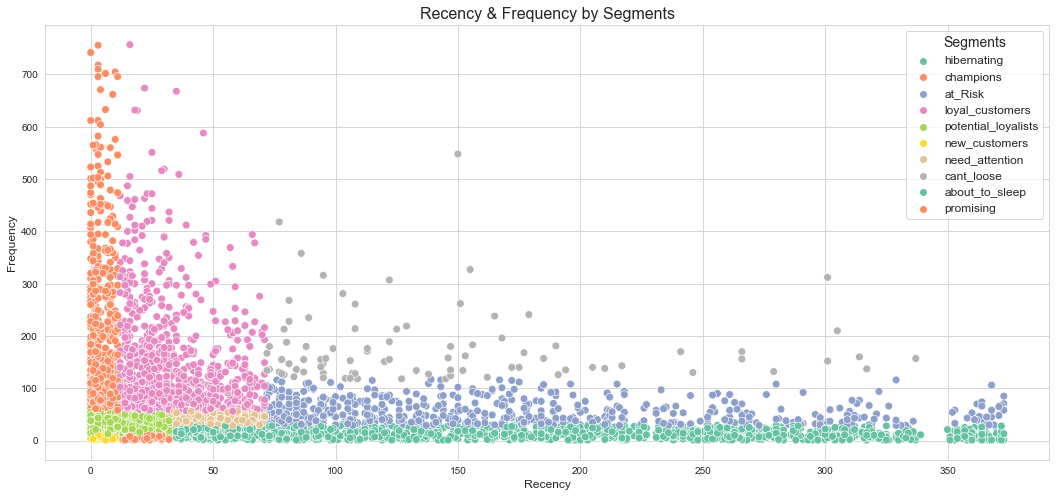

In [31]:
plt.figure(figsize = (18, 8))
sns.scatterplot(data = rfm, x = 'Recency',
                y = 'Frequency', hue ='segment', palette= palette, s = 60)
plt.title('Recency & Frequency by Segments', size = 16)
plt.xlabel('Recency', size = 12)
plt.ylabel('Frequency', size = 12)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.legend(loc = 'best', fontsize = 12,
           title = 'Segments',title_fontsize=14)
plt.show()


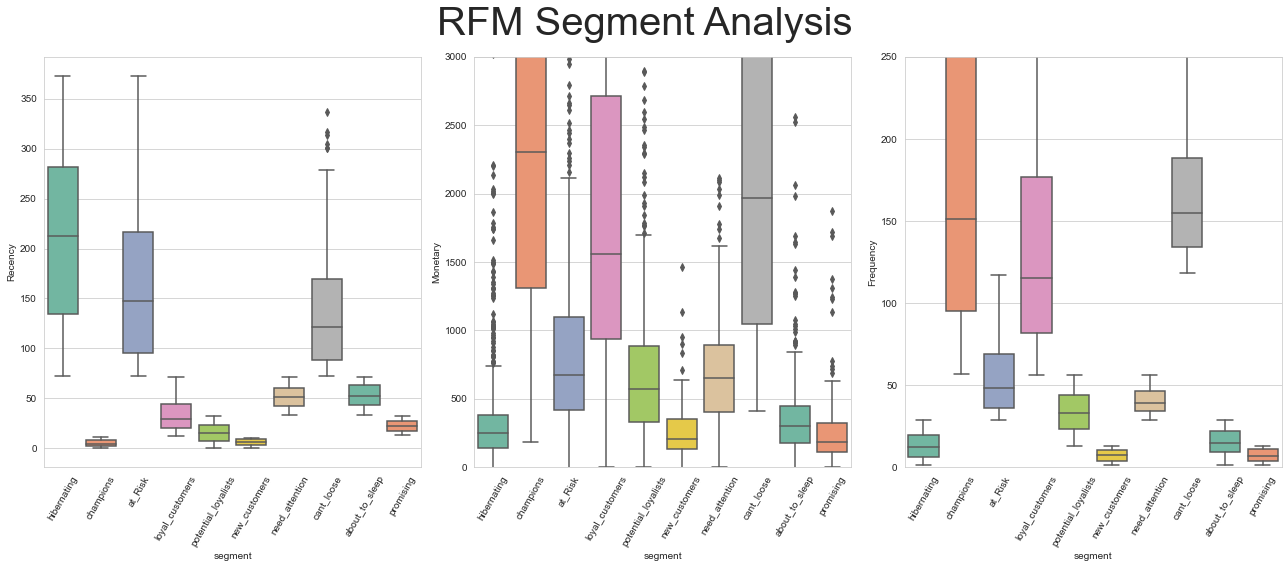

In [32]:
fig, axes = plt.subplots(1,3, figsize = (18, 8))
fig.suptitle('RFM Segment Analysis', size = 40)
feature_list = ['Recency', 'Monetary', 'Frequency']
for idx, col in enumerate(feature_list):
    sns.boxplot(ax = axes[idx], data = rfm,
                x = 'segment', y = feature_list[idx],
                palette= palette)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=60)
    if idx == 1:
        axes[idx].set_ylim([0, 3000])
    if idx == 2:
        axes[idx].set_ylim([0, 250])
plt.tight_layout()
plt.show()

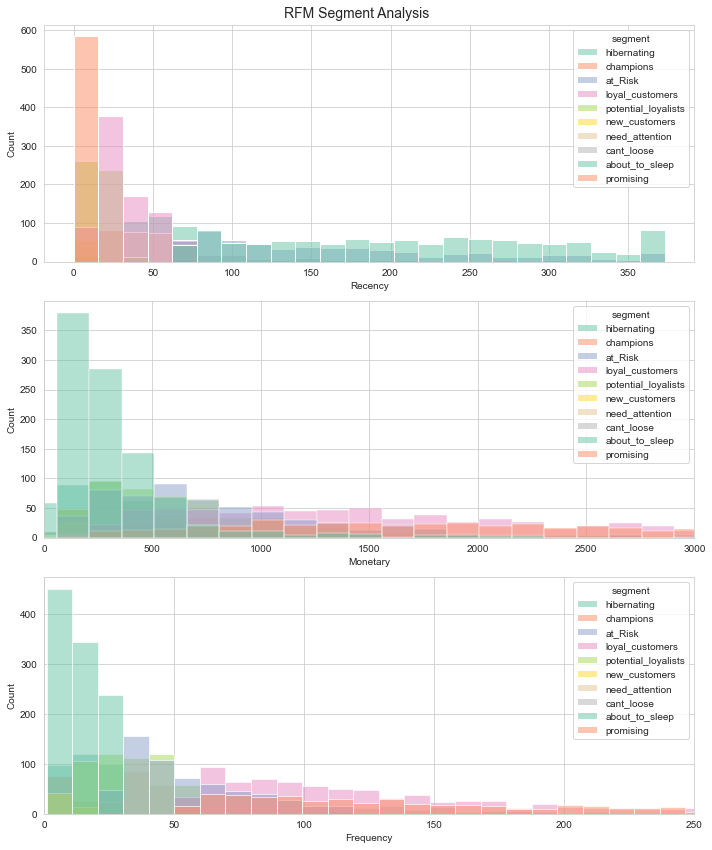

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('RFM Segment Analysis', size = 14)
feature_list = ['Recency', 'Monetary', 'Frequency']
for idx, col in enumerate(feature_list):
    sns.histplot(ax = axes[idx], data = rfm,
                 hue = 'segment', x = feature_list[idx],
                 palette= palette)
    if idx == 1:
        axes[idx].set_xlim([0, 3000])
    if idx == 2:
        axes[idx].set_xlim([0, 250])
plt.tight_layout()
plt.show()


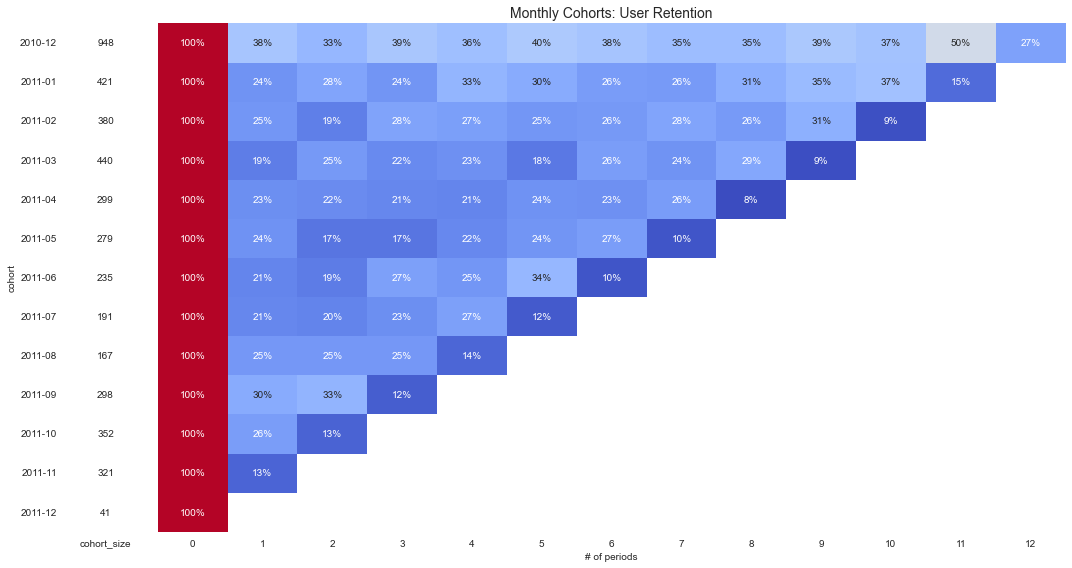

In [34]:
def CohortAnalysis(dataframe):
    
    data = dataframe.copy()
    data = data[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()
    data['order_month'] = data['InvoiceDate'].dt.to_period('M')
    data['cohort'] = data.groupby('CustomerID')['InvoiceDate']\
    .transform('min').dt.to_period('M')
    cohort_data = data.groupby(['cohort', 'order_month'])\
    .agg(n_customers=('CustomerID', 'nunique')).reset_index(drop=False)
    cohort_data['period_number'] = (cohort_data.order_month - cohort_data.cohort)\
    .apply(attrgetter('n'))
    cohort_pivot = cohort_data.pivot_table(index = 'cohort',
                                           columns = 'period_number',
                                           values = 'n_customers')
    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(15, 8),
                        sharey=True,
                        gridspec_kw={'width_ratios': [1, 11]})
        sns.heatmap(retention_matrix, 
                    mask = retention_matrix.isnull(), 
                    annot = True,
                    cbar = False,
                    fmt='.0%', 
                    cmap='coolwarm', ax=ax[1])
        ax[1].set_title('Monthly Cohorts: User Retention', fontsize=14)
        ax[1].set(xlabel='# of periods',
                  ylabel='')
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'}), 
                    annot=True, 
                    cbar = False,
                    fmt='g',
                    cmap=white_cmap,
                    ax=ax[0])
        fig.tight_layout()
    
CohortAnalysis(retail)

In [35]:
cltv_df = retail.groupby('CustomerID').agg({'InvoiceDate': [lambda x: (x.max() - x.min()).days,
                                                        lambda x: (max_date - x.min()).days], 
                                        'InvoiceNo': lambda x: x.nunique(),
                                        'TotalPrice': lambda x: x.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['Recency', 'T', 'Frequency', 'Monetary']
cltv_df.head()

Recency    T  Frequency  Monetary
CustomerID                                   
12346.0           0  325          2      0.00
12347.0         365  366          7   4310.00
12348.0         282  357          4   1797.24
12349.0           0   18          1   1757.55
12350.0           0  309          1    334.40

In [36]:
#Average Order Value
cltv_df["Monetary"] = cltv_df["Monetary"] / cltv_df["Frequency"]

#Recency & Tenure
cltv_df["Recency"] = cltv_df["Recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

#Frequency
cltv_df = cltv_df[(cltv_df['Frequency'] > 1)]

In [37]:
BGF = BetaGeoFitter(penalizer_coef = 0.001) #avoid overfitting

BGF.fit(cltv_df['Frequency'],
        cltv_df['Recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 3059 subjects, a: 0.19, alpha: 7.57, b: 2.78, r: 1.89>

In [38]:
BGF.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['Frequency'],
                                                        cltv_df['Recency'],
                                                        cltv_df['T']
                                                       ).sort_values(ascending = False)\
.head(10)\
.to_frame('Expected Number of Transactions')\
.reset_index()

CustomerID  Expected Number of Transactions
0    14911.0                         4.106791
1    12748.0                         3.701211
2    17841.0                         2.805967
3    14606.0                         2.133177
4    13089.0                         1.978495
5    15311.0                         1.964095
6    14096.0                         1.603266
7    12971.0                         1.492472
8    14527.0                         1.437459
9    13408.0                         1.355527

In [39]:
BGF.conditional_expected_number_of_purchases_up_to_time(4,
                                                        cltv_df['Frequency'],
                                                        cltv_df['Recency'],
                                                        cltv_df['T']
                                                       ).sort_values(ascending = False)\
.head(10)\
.to_frame('Expected Number of Transactions')\
.reset_index()


CustomerID  Expected Number of Transactions
0    14911.0                        16.353211
1    12748.0                        14.738349
2    17841.0                        11.173346
3    14606.0                         8.494307
4    13089.0                         7.878118
5    15311.0                         7.821104
6    14096.0                         6.337426
7    12971.0                         5.942963
8    14527.0                         5.724026
9    13408.0                         5.397767

# Frequency of Repeat Transactions

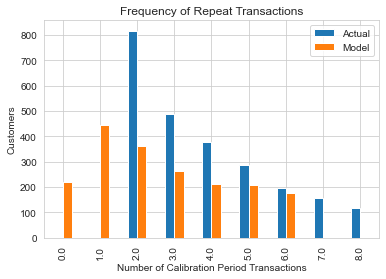

In [40]:
#Plot a figure with period actual and predicted transactions.
plot_period_transactions(BGF,
                         max_frequency = 7)
plt.show()

In [41]:
from sklearn.preprocessing import StandardScaler

#rescaling the attributes
rfm_df=rfm[['Monetary','Frequency','Recency']]
#instantiate
scaler=StandardScaler()
#fit_transform
rfm_df_scaled=scaler.fit_transform(rfm_df) #mean=0,std=1
rfm_df_scaled

array([[-0.73883491, -0.74987222,  2.3007653 ],
       [ 1.79662655,  1.0412316 , -0.90690322],
       [ 0.31843487, -0.46130549, -0.18418778],
       ...,
       [-0.6349457 , -0.64041587, -0.84750195],
       [ 0.49352878,  6.75286265, -0.8871028 ],
       [ 0.34198937, -0.073233  , -0.50099455]])

In [42]:
#rfm_df_scaled
rfm_df_scaled.shape

(4290, 3)

In [43]:
rfm_df_scaled=pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns=['Monetary','Frequency','Recency']
rfm_df_scaled.head()

Monetary  Frequency   Recency
0 -0.738835  -0.749872  2.300765
1  1.796627   1.041232 -0.906903
2  0.318435  -0.461305 -0.184188
3  0.295086  -0.043381 -0.738600
4 -0.542116  -0.600614  2.142362

# K-means clustering model building

In [44]:
#k-means with some arbitrary k
#the number of centroids you need in the dataset
from sklearn.cluster import KMeans

kmeans= KMeans(n_clusters=4)
kmeans.fit(rfm_df_scaled)

KMeans(n_clusters=4)

In [45]:
kmeans.labels_ #to set the k mean labels

array([2, 0, 1, ..., 1, 3, 1])

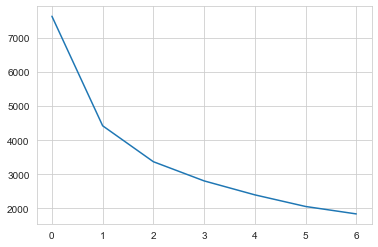

In [46]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [47]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.537506551504052
For n_clusters=3, the silhouette score is 0.5070934441124859
For n_clusters=4, the silhouette score is 0.47715297341949986
For n_clusters=5, the silhouette score is 0.46841885273112277
For n_clusters=6, the silhouette score is 0.41778537980929786
For n_clusters=7, the silhouette score is 0.41182055537367934
For n_clusters=8, the silhouette score is 0.40661332912810755


In [48]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [49]:
 kmeans.labels_

array([1, 2, 0, ..., 0, 2, 0])

In [50]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

CustomerID  Recency  Frequency  Monetary recency_score frequency_score  \
0    12346.0      325          2      0.00             1               1   
1    12347.0        1        182   4310.00             5               5   
2    12348.0       74         31   1797.24             2               3   
3    12349.0       18         73   1757.55             4               4   
4    12350.0      309         17    334.40             1               2   

  monetary_score RFM_SCORE          segment  Cluster_Id  
0              1        11      hibernating           1  
1              5        55        champions           2  
2              4        23          at_Risk           0  
3              4        44  loyal_customers           0  
4              2        12      hibernating           1

<AxesSubplot:xlabel='Cluster_Id', ylabel='Monetary'>

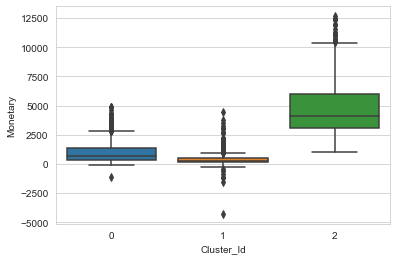

In [51]:
# Box plot to visualize Cluster Id vs Monetary

sns.boxplot(x='Cluster_Id', y='Monetary', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

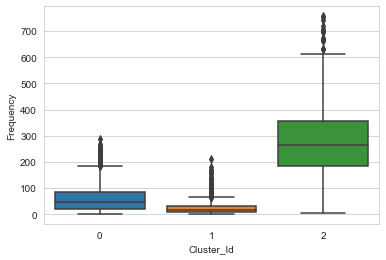

In [52]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

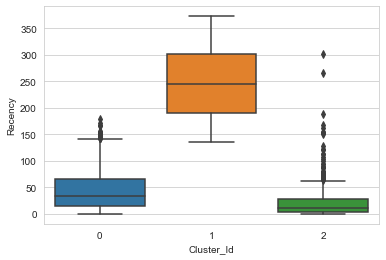

In [53]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

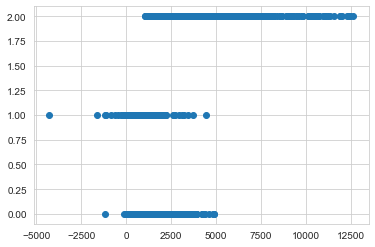

In [54]:
plt.scatter(rfm['Monetary'],rfm['Cluster_Id'])

In [55]:
rfm

CustomerID  Recency  Frequency  Monetary recency_score frequency_score  \
0       12346.0      325          2      0.00             1               1   
1       12347.0        1        182   4310.00             5               5   
2       12348.0       74         31   1797.24             2               3   
3       12349.0       18         73   1757.55             4               4   
4       12350.0      309         17    334.40             1               2   
...         ...      ...        ...       ...           ...             ...   
4367    18280.0      277         10    180.60             1               1   
4368    18281.0      180          7     80.82             2               1   
4369    18282.0        7         13    176.60             5               2   
4370    18283.0        3        756   2094.88             5               5   
4371    18287.0       42         70   1837.28             3               4   

     monetary_score RFM_SCORE              segment  Cluster_Id  
0                 1        11          hibernating           1  
1                 5        55            champions           2  
2                 4        23              at_Risk           0  
3                 4        44      loyal_customers           0  
4                 2        12          hibernating           1  
...             ...       ...                  ...         ...  
4367              1        11          hibernating           1  
4368              1        21          hibernating           1  
4369              1        52  potential_loyalists           0  
4370              5        55            champions           2  
4371              4        34      loyal_customers           0  

[4290 rows x 10 columns]

In [56]:
rfm[rfm['Cluster_Id']==0]

CustomerID  Recency  Frequency  Monetary recency_score frequency_score  \
2       12348.0       74         31   1797.24             2               3   
3       12349.0       18         73   1757.55             4               4   
5       12352.0       35         95   1545.41             3               4   
9       12356.0       22         59   2811.43             4               4   
11      12358.0        1         19   1168.06             5               2   
...         ...      ...        ...       ...           ...             ...   
4364    18276.0       20         16    323.36             4               2   
4365    18277.0       57          9     97.63             3               1   
4366    18278.0       73          9    173.90             2               1   
4369    18282.0        7         13    176.60             5               2   
4371    18287.0       42         70   1837.28             3               4   

     monetary_score RFM_SCORE              segment  Cluster_Id  
2                 4        23              at_Risk           0  
3                 4        44      loyal_customers           0  
5                 4        34      loyal_customers           0  
9                 5        44      loyal_customers           0  
11                4        52  potential_loyalists           0  
...             ...       ...                  ...         ...  
4364              2        42  potential_loyalists           0  
4365              1        31       about_to_sleep           0  
4366              1        21          hibernating           0  
4369              1        52  potential_loyalists           0  
4371              4        34      loyal_customers           0  

[2722 rows x 10 columns]

In [57]:
rfm[rfm['Cluster_Id']==1]

CustomerID  Recency  Frequency  Monetary recency_score frequency_score  \
0       12346.0      325          2      0.00             1               1   
4       12350.0      309         17    334.40             1               2   
6       12353.0      203          4     89.00             1               1   
7       12354.0      231         58   1079.40             1               4   
8       12355.0      213         13    459.40             1               1   
...         ...      ...        ...       ...           ...             ...   
4350    18256.0      354          4    -50.10             1               1   
4355    18262.0      139         13    149.48             2               2   
4359    18269.0      357          8    138.90             1               1   
4367    18280.0      277         10    180.60             1               1   
4368    18281.0      180          7     80.82             2               1   

     monetary_score RFM_SCORE      segment  Cluster_Id  
0                 1        11  hibernating           1  
4                 2        12  hibernating           1  
6                 1        11  hibernating           1  
7                 4        14      at_Risk           1  
8                 3        11  hibernating           1  
...             ...       ...          ...         ...  
4350              1        11  hibernating           1  
4355              1        22  hibernating           1  
4359              1        11  hibernating           1  
4367              1        11  hibernating           1  
4368              1        21  hibernating           1  

[1068 rows x 10 columns]

In [58]:
rfm[rfm['Cluster_Id']==2]

CustomerID  Recency  Frequency  Monetary recency_score frequency_score  \
1       12347.0        1        182   4310.00             5               5   
10      12357.0       32        131   6207.67             4               5   
12      12359.0        7        254   6245.53             5               5   
15      12362.0        2        274   5154.58             5               5   
20      12370.0       50        167   3545.69             3               5   
...         ...      ...        ...       ...           ...             ...   
4326    18225.0        2        286   5361.02             5               5   
4327    18226.0       38        245   5192.10             3               5   
4330    18229.0       11        164   7276.90             5               5   
4361    18272.0        2        170   3064.78             5               5   
4370    18283.0        3        756   2094.88             5               5   

     monetary_score RFM_SCORE          segment  Cluster_Id  
1                 5        55        champions           2  
10                5        45  loyal_customers           2  
12                5        55        champions           2  
15                5        55        champions           2  
20                5        35  loyal_customers           2  
...             ...       ...              ...         ...  
4326              5        55        champions           2  
4327              5        35  loyal_customers           2  
4330              5        55        champions           2  
4361              5        55        champions           2  
4370              5        55        champions           2  

[500 rows x 10 columns]

# Hierarchial clustering

In [59]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

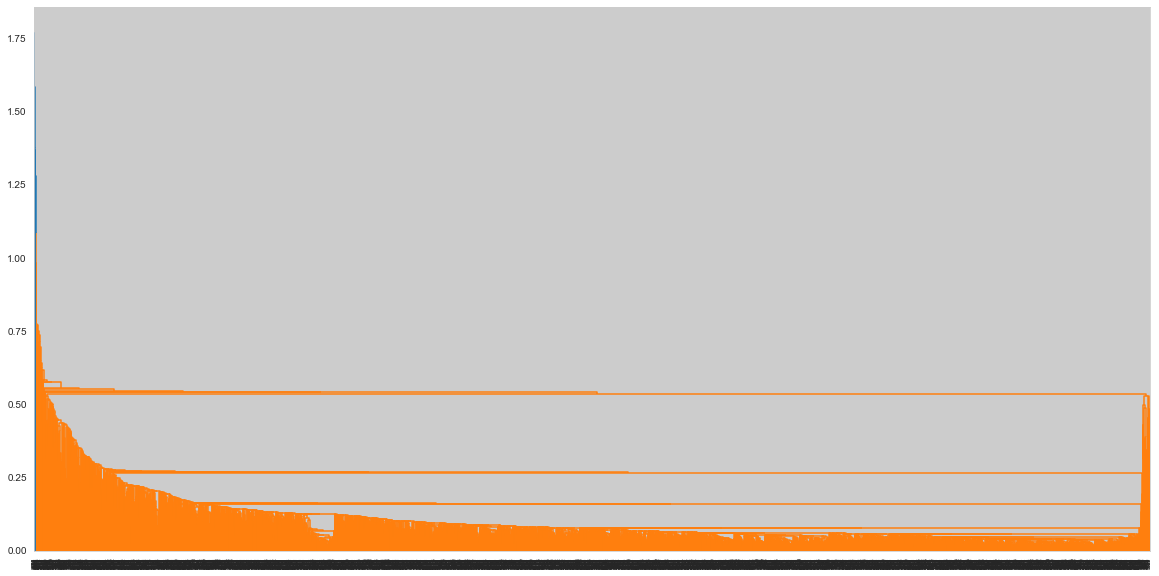

In [60]:
# Single linkage: 
plt.figure(figsize = (20,10))
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

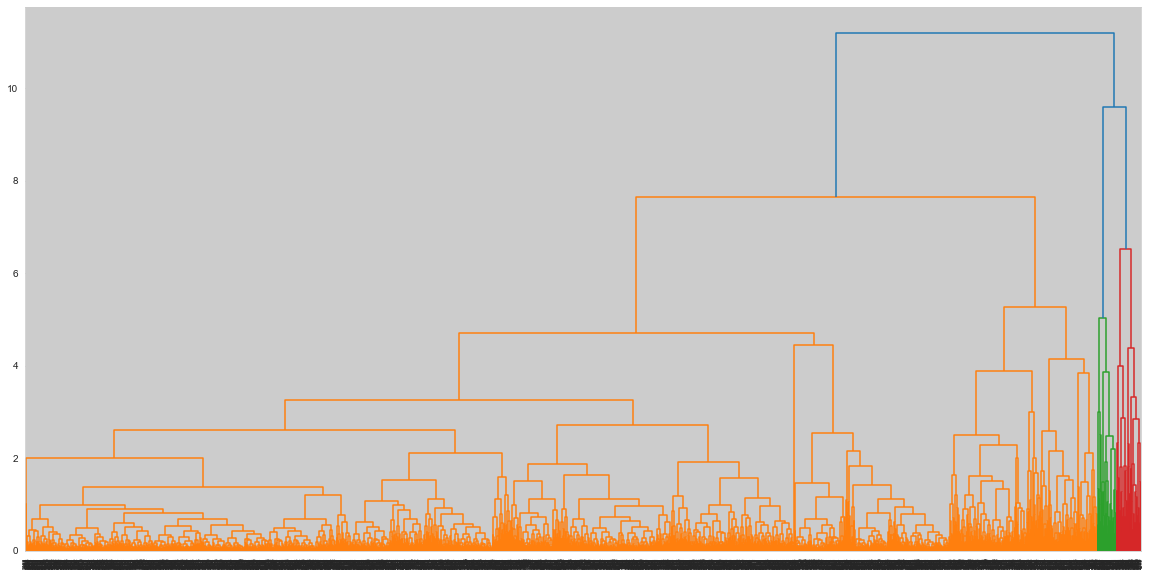

In [61]:
# Complete linkage
plt.figure(figsize = (20,10))
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

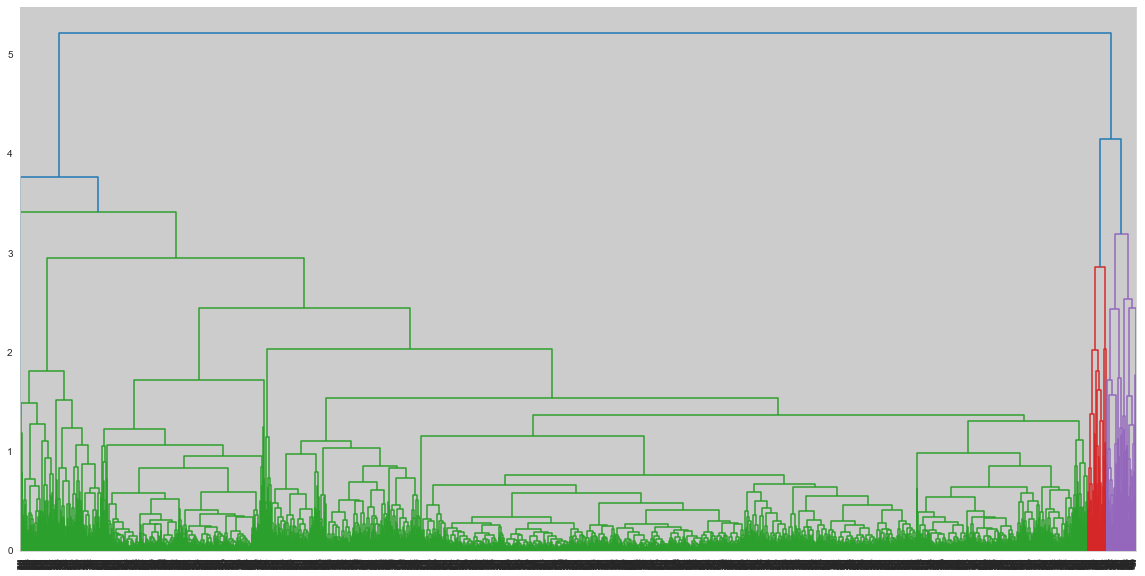

In [62]:
# Average linkage
plt.figure(figsize = (20,10))
mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

In [63]:
# 3 clusters
from scipy.cluster.hierarchy import cut_tree
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 2, 0])

In [64]:
# Assign cluster labels

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

CustomerID  Recency  Frequency  Monetary recency_score frequency_score  \
0    12346.0      325          2      0.00             1               1   
1    12347.0        1        182   4310.00             5               5   
2    12348.0       74         31   1797.24             2               3   
3    12349.0       18         73   1757.55             4               4   
4    12350.0      309         17    334.40             1               2   

  monetary_score RFM_SCORE          segment  Cluster_Id  Cluster_Labels  
0              1        11      hibernating           1               0  
1              5        55        champions           2               0  
2              4        23          at_Risk           0               0  
3              4        44  loyal_customers           0               0  
4              2        12      hibernating           1               0

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Monetary'>

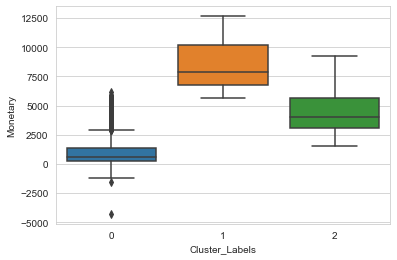

In [65]:
# Plot Cluster Id vs Monetary

sns.boxplot(x='Cluster_Labels', y='Monetary', data=rfm)

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Frequency'>

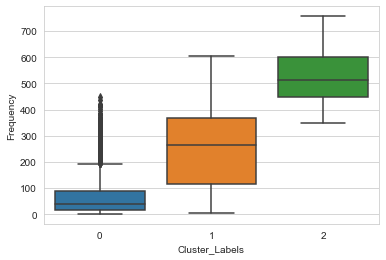

In [66]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Recency'>

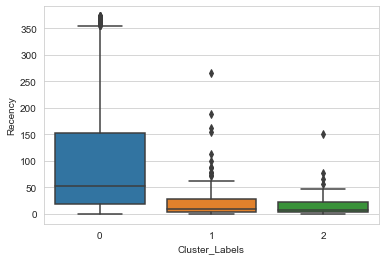

In [67]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

In [68]:
rfm[rfm['Cluster_Labels']==0]

CustomerID  Recency  Frequency  Monetary recency_score frequency_score  \
0       12346.0      325          2      0.00             1               1   
1       12347.0        1        182   4310.00             5               5   
2       12348.0       74         31   1797.24             2               3   
3       12349.0       18         73   1757.55             4               4   
4       12350.0      309         17    334.40             1               2   
...         ...      ...        ...       ...           ...             ...   
4366    18278.0       73          9    173.90             2               1   
4367    18280.0      277         10    180.60             1               1   
4368    18281.0      180          7     80.82             2               1   
4369    18282.0        7         13    176.60             5               2   
4371    18287.0       42         70   1837.28             3               4   

     monetary_score RFM_SCORE              segment  Cluster_Id  Cluster_Labels  
0                 1        11          hibernating           1               0  
1                 5        55            champions           2               0  
2                 4        23              at_Risk           0               0  
3                 4        44      loyal_customers           0               0  
4                 2        12          hibernating           1               0  
...             ...       ...                  ...         ...             ...  
4366              1        21          hibernating           0               0  
4367              1        11          hibernating           1               0  
4368              1        21          hibernating           1               0  
4369              1        52  potential_loyalists           0               0  
4371              4        34      loyal_customers           0               0  

[4106 rows x 11 columns]

In [69]:
rfm[rfm['Cluster_Labels']==1]

CustomerID  Recency  Frequency  Monetary recency_score frequency_score  \
10      12357.0       32        131   6207.67             4               5   
12      12359.0        7        254   6245.53             5               5   
50      12409.0       78        114  11056.93             2               4   
66      12428.0       25        300   7877.20             4               5   
69      12431.0       35        240   6416.39             3               5   
...         ...      ...        ...       ...           ...             ...   
4238    18109.0        1        454   7925.32             5               5   
4260    18139.0       16        162   8393.22             4               5   
4285    18172.0       14        197   7490.17             4               5   
4324    18223.0        1        299   6315.23             5               5   
4330    18229.0       11        164   7276.90             5               5   

     monetary_score RFM_SCORE          segment  Cluster_Id  Cluster_Labels  
10                5        45  loyal_customers           2               1  
12                5        55        champions           2               1  
50                5        24          at_Risk           2               1  
66                5        45  loyal_customers           2               1  
69                5        35  loyal_customers           2               1  
...             ...       ...              ...         ...             ...  
4238              5        55        champions           2               1  
4260              5        45  loyal_customers           2               1  
4285              5        45  loyal_customers           2               1  
4324              5        55        champions           2               1  
4330              5        55        champions           2               1  

[113 rows x 11 columns]

In [70]:
rfm[rfm['Cluster_Labels']==2]

CustomerID  Recency  Frequency  Monetary recency_score frequency_score  \
101     12472.0       30        391   6229.48             4               5   
112     12484.0       32        350   4495.27             4               5   
238     12637.0       66        394   5953.25             3               5   
338     12757.0       15        377   4227.70             4               5   
395     12841.0        4        439   3876.40             5               5   
...         ...      ...        ...       ...           ...             ...   
4103    17920.0        3        696   4204.10             5               5   
4128    17954.0        4        489   2295.37             5               5   
4189    18041.0       11        474   4161.14             5               5   
4208    18069.0       25        472   2021.82             4               5   
4370    18283.0        3        756   2094.88             5               5   

     monetary_score RFM_SCORE          segment  Cluster_Id  Cluster_Labels  
101               5        45  loyal_customers           2               2  
112               5        45  loyal_customers           2               2  
238               5        35  loyal_customers           2               2  
338               5        45  loyal_customers           2               2  
395               5        55        champions           2               2  
...             ...       ...              ...         ...             ...  
4103              5        55        champions           2               2  
4128              5        55        champions           2               2  
4189              5        55        champions           2               2  
4208              5        45  loyal_customers           2               2  
4370              5        55        champions           2               2  

[71 rows x 11 columns]